Задание: объекты культурного наследия России

Изучите набор данных по объектам культурного наследия России (в виде gz-архива):
https://video.ittensive.com/python-advanced/data-44-structure-4.csv.gz
и постройте фоновую картограмму по количеству объектов в каждом регионе России, используя гео-данные
https://video.ittensive.com/python-advanced/russia.json

Выведите для каждого региона количество объектов в нем.

Посчитайте число объектов культурного наследия в Татарстане. 

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import descartes

data_kn = pd.read_csv("https://video.ittensive.com/python-advanced/data-44-structure-4.csv.gz", low_memory=False)  # данные весят 20 мб, чтобы не ждать каждый раз загрузки с сервера, скачайте и спользуйте локально
# data_kn = pd.read_csv("data-44-structure-4.csv.gz", low_memory=False)

pd.set_option('display.max_columns', None)  # применим параметр для pandas, чтобы увидить все колонки данных
data_kn["Регион"] = data_kn["Регион"].str.upper()  # приведем к верхнему регистру, чтобы избежать проблем при объединении
val_obj = data_kn.groupby('Регион').size().to_frame('val_obj').reset_index()  # сгруппируем и посчитаем объектов КН в регионе
val_obj["Title"] = val_obj["Регион"].astype(str) + " - " + val_obj["val_obj"].astype(str)  # добавим еще одну серию данных регион и кол-во объектов КН
val_obj_alt = val_obj.set_index("Регион")["Title"]

print(val_obj_alt.loc["АЛТАЙСКИЙ КРАЙ"])

АЛТАЙСКИЙ КРАЙ - 4480


In [35]:

#На карте, Регион
# подготовим геоданные 
#data = gpd.read_file("russia.json")  # загрузим данные в геопандас (файл весит много, лучше скачать и использовать локально, для ускорения обработки)
data = gpd.read_file("https://video.ittensive.com/python-advanced/russia.json")  # загрузим данные в геопфндас

data = data.to_crs('epsg:3857')  # приведем к Меркатор
data["NL_NAME_1"] = data["NL_NAME_1"].str.upper()  # приведем к верхнему регистру, чтобы избежать проблем при объединении
#print(data["NL_NAME_1"].head(7))
# * см ниже - Унификация наборов данных
# при обьединении нужно устранить нестыковки данных, заменим различающиеся названия регионов на что-то одно
data = data.replace({
    "ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ": "ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА",
    "РЕСПУБЛИКА АДЫГЕЯ": "РЕСПУБЛИКА АДЫГЕЯ (АДЫГЕЯ)",
    "ЧУВАШСКАЯ РЕСПУБЛИКА": "ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ",
    "РЕСПУБЛИКА МАРИЙ-ЭЛ": "РЕСПУБЛИКА МАРИЙ ЭЛ",
    "РЕСПУБЛИКА СЕВЕРНАЯ ОСЕТИЯ": "РЕСПУБЛИКА СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ",
    "РЕСПУБЛИКА ТАТАРСТАН": "РЕСПУБЛИКА ТАТАРСТАН (ТАТАРСТАН)"
})
# Объеденим геоданные и данные 
data = pd.merge(left=data, right=val_obj,
             left_on="NL_NAME_1", right_on="Регион", how="left")
# чтобы найти проблему по регионам, какие названия у нас расходятся выведем все строки где поле Объект, т.е. число объектов в регионе NULL
# т.е. те где объединение не прошло корректно, региона небыло в исходном наборе
print(data[data["val_obj"].isnull()])

# таких регионов вышло 6! 
# теперь нужно заменить из названия в гео наборе на нужные или в исходном наборе на названия гео набора 
# в любом случае нужно унифицировать названия одного и тогоже региона в обоих наборах данных
# для этого выведем индекс основного набора данных (data_kn) и найдем все расхождения которые уже выведены в объедененном наборе
# после этого, для замены, применим replace  к данным и заменим одно название на другое 
# * замену см. выше

#print(val_obj_alt.to_string())
tatarstan = data[data["Регион"] == "РЕСПУБЛИКА ТАТАРСТАН (ТАТАРСТАН)"].reset_index()  # фильтруем данные выбрав только Татарстан

print("В республике ТАТАРСТАН число объектов культурного наследия составляет:", tatarstan.val_obj[0])  # посчитаем число объектов культурного наследия в Татарстане.  

Empty GeoDataFrame
Columns: [ID_0, ISO, NAME_0, ID_1, NAME_1, NL_NAME_1, VARNAME_1, TYPE_1, ENGTYPE_1, geometry, Регион, val_obj, Title]
Index: []
В республике ТАТАРСТАН число объектов культурного наследия составляет: 1616


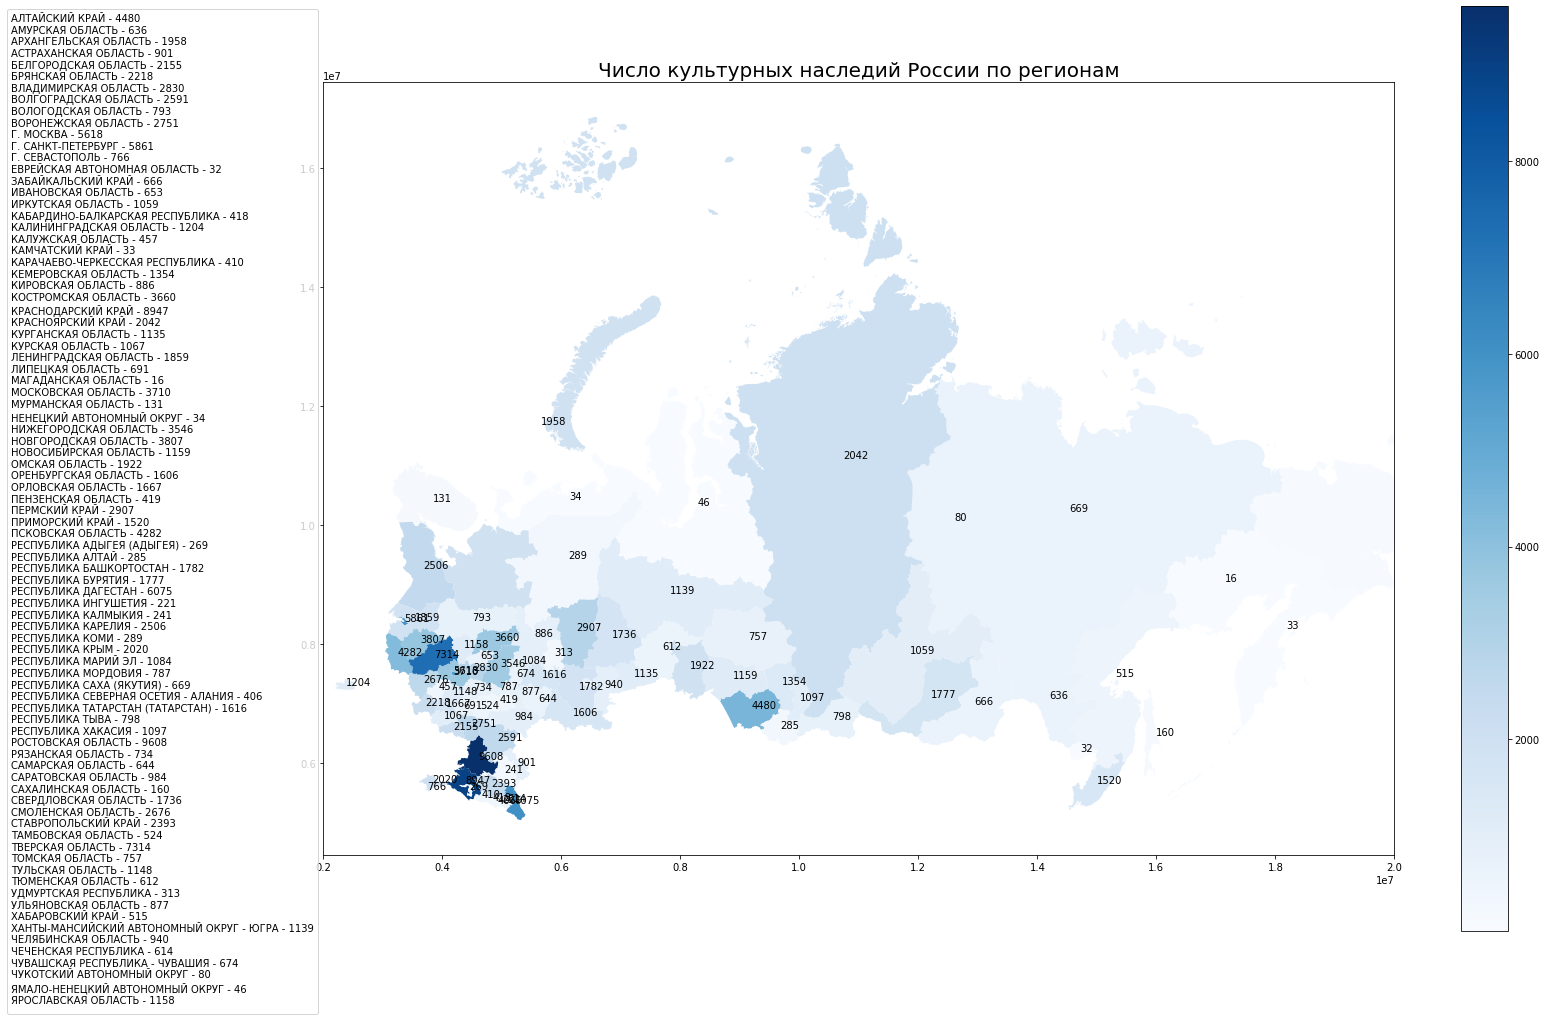

In [183]:
# Фоновая картограмма 
fig = plt.figure(figsize=(24,17))
area = plt.subplot(1, 1, 1)
data.plot(ax=area, legend=True, column="val_obj", cmap="Blues",)
# обрежим данные (Чукотку и то что западнее Калининграда) т.е. зададим лимиты по оси х, через set_xlim, 
# заметим что координаты указаны в десятках м-н (1е7) поэтому нам нужен диапазон от 2х м-н до 20 м-н (от 2е6 до 2е7) 
area.set_xlim(2e6, 2e7) # обрежим данные и карта станет нормально отображатся 
for _,v_o in data.iterrows():  # на несем число КН в регионах на карту 
    area.annotate(v_o.val_obj, 
                  xy=(v_o.geometry.centroid.x, v_o.geometry.centroid.y))
# выведм легенду с подписями региона и кол-вом объектов культ.наследия 
area.legend([], title="\n".join(val_obj.Title), bbox_to_anchor=(0, 0.1, 0, 1))
# добавим общий заголовок для всех картограммы loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5)
plt.title("Число культурных наследий России по регионам", fontsize=20 )
plt.show()

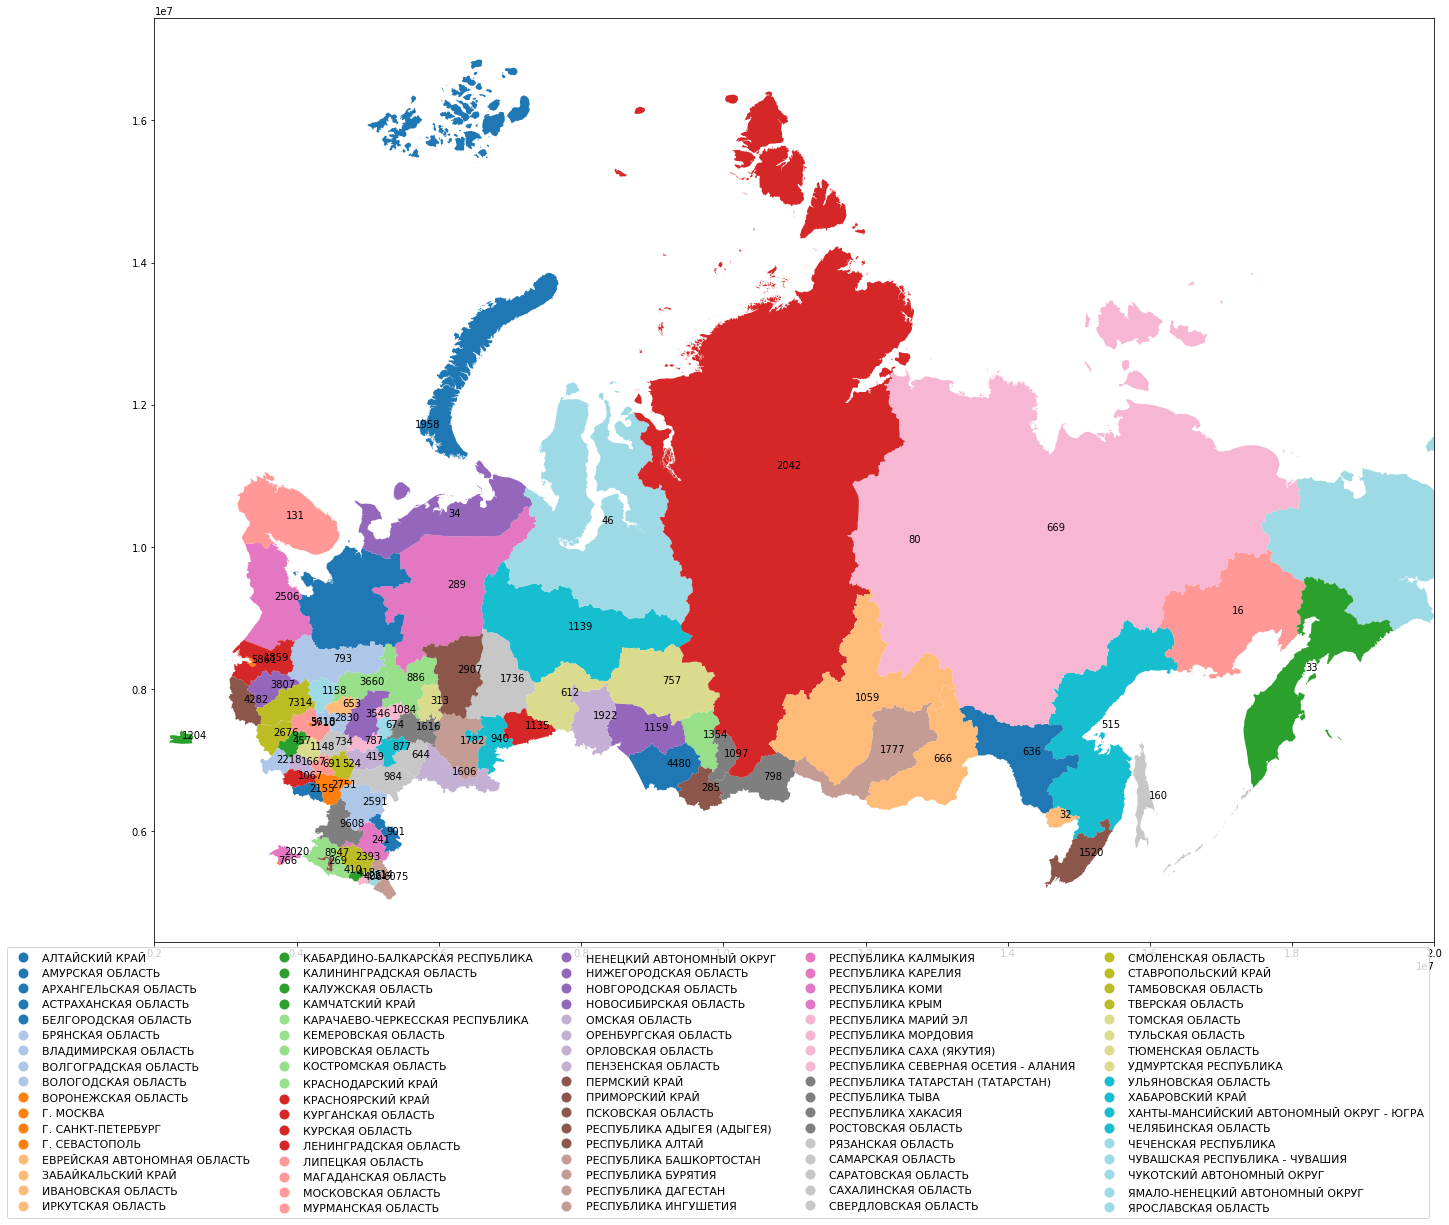

In [182]:
# отрисуем гео данные на холсте 
fig = plt.figure(figsize=(24,17))
area = plt.subplot(1, 1, 1)
data.plot(ax=area, legend=True, column="NL_NAME_1",
        lw=0.5, cmap="tab20",
         legend_kwds = {"ncol":5,
                        "bbox_to_anchor": (1, 0, 0, 0),
                        "fontsize": 11 })
# обрежим данные (Чукотку и то что западнее Калининграда)
# т.е. зададим лимиты по оси х, через set_xlim, 
# заметим что координаты указаны в десятках м-н (1е7) поэтому нам нужен диапазон от 2х м-н до 20 м-н (от 2е6 до 2е7) 
area.set_xlim(2e6, 2e7) # обрежим данные 
for _,v_o in data.iterrows(): # на несем число КН в регионах на карту 
    area.annotate(v_o.val_obj, 
                  xy=(v_o.geometry.centroid.x, v_o.geometry.centroid.y))

plt.show()